In [22]:
import torch

# # 1. Chỉ tải tensor hoặc dict đã save
# data = torch.load('path/to/data.pt', map_location='cpu')
# # → nếu bạn save một dict như {'inputs':…, 'labels':…}, giờ bạn có thể truy cập:
# inputs, labels = data['inputs'], data['labels']

# 3. Nếu file .pt thực chất chỉ là tensor đơn lẻ
tensor = torch.load('raw1_seq_10.pt', map_location='cpu')  # hoặc 'cpu'
# print(tensor.shape)  # in ra kích thước của tensor
print(tensor['label'])  # in ra tensor



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [9]:
print(tensor['sequence'][0].shape)  # in ra kích thước của tensor

torch.Size([1, 32, 32])


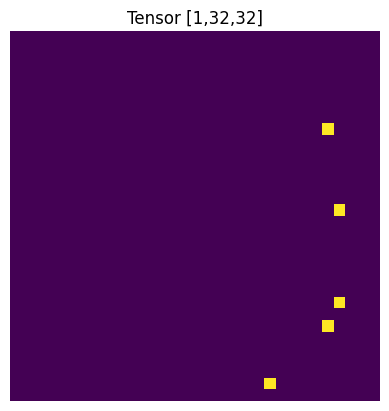

In [26]:
import torch
import matplotlib.pyplot as plt

# Giả sử bạn đã load tensor có shape [1, 32, 32] vào biến `tensor`
# Ví dụ:
# tensor = torch.load('path/to/data.pt', map_location='cpu')

# Bỏ chiều channel
img = tensor['sequence'][299].squeeze(0)   # giờ shape là [32, 32]

# Hiển thị
plt.imshow(img)           # không chỉ định colormap thì dùng mặc định
plt.title('Tensor [1,32,32]')
plt.axis('off')           # tắt hiển thị trục nếu muốn
plt.show()


In [1]:
from src.data.preprocessing import dv_data_frame_tSlice
import os
from datetime import timedelta
import dv_processing as dv
import torch
from torchvision import transforms
import rootutils
import pandas as pd
import numpy as np

import src.data.events_encoding as ev_enc


In [2]:
normalize_param = {
    'accumulate': (0.5, 0.01),
    'time_surface': (0.0, 0.03),
    'custom': (0.0, 0.003)
}

In [3]:
def dv_data_frame_tSlice(file_path, duration=10, encoding_type='accumulate' ):
    """
    Extract frames from a .aedat4 file using a time slice.
    Args:
        file_path: str
        duration (milliseconds): int
        press_times_list: list of time (every 2 elements are a pair of start time and end time)
        encoding_type: str ('accumulate', 'time_surface', 'custom')
    Returns:
        list[np.ndarray]: frames (each of shape (H, W))
        list[int]: labels (0 for no press and 1 for press)
    """
    capture = dv.io.MonoCameraRecording(file_path)
    
    frames = []

    if not capture.isEventStreamAvailable():
        raise RuntimeError("Input camera does not provide an event stream.")

    slicer = dv.EventStreamSlicer()
    if encoding_type == 'accumulate':
        encoding_func = ev_enc.accumulate_dv_encode
    elif encoding_type == 'time_surface':
        encoding_func = ev_enc.timesurface_dv_encode
    elif encoding_type == 'custom':
        encoding_func = ev_enc.custom_encode

    def slicing_callback(events: dv.EventStore):
        frame = encoding_func(events, capture.getEventResolution())
        frames.append(frame)

    slicer.doEveryTimeInterval(timedelta(milliseconds=duration), slicing_callback)

    while capture.isRunning():
        events = capture.getNextEventBatch()
        if events is not None:
            slicer.accept(events)
    return frames

In [5]:
frame = dv_data_frame_tSlice(r'data\raw_data\raw1.aedat4', duration=10, encoding_type='accumulate')

In [11]:
frame[1000]

array([[128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       ...,
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128],
       [128, 128, 128, ..., 128, 128, 128]], dtype=uint8)

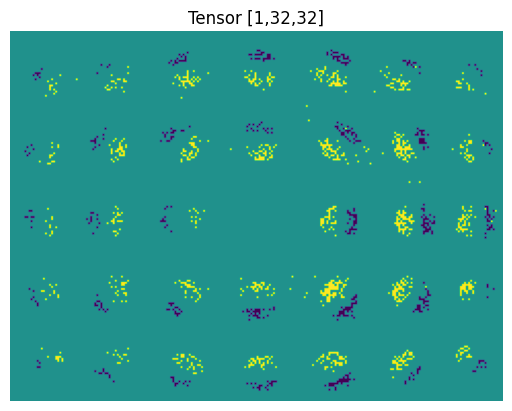

In [19]:
import torch
import matplotlib.pyplot as plt
# Hiển thị
plt.imshow(frame[602])           # không chỉ định colormap thì dùng mặc định
plt.title('Tensor [1,32,32]')
plt.axis('off')           # tắt hiển thị trục nếu muốn
plt.show()


In [6]:
def preprocess_frames(frames, encoding_type='accumulate', target_size=(32, 32)):
    mean, std = normalize_param[encoding_type]

    # class MinMaxTransform:
    #     def __call__(self, img):
    #         min_val = img.min()
    #         max_val = img.max()
    #         if max_val > min_val:  # Avoid division by zero
    #             img = (img - min_val) / (max_val - min_val)
    #         return img
    
    class ClipTransform:
        def __call__(self, img):
            return torch.clamp(img, 0, 5)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),  # Resize the images if needed
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),         # Convert images to tensor
        transforms.Normalize(mean=mean, std=std),  # Normalize
        # ClipTransform(),               # Clip values to be inside [0, 1]
        # MinMaxTransform()
    ])

    # class SplitChannelsTransform:
    #     def __call__(self, img):
    #         # Split d channels into list of (H, W) tensors
    #         return [img[i] for i in range(img.shape[0])]

    # class MergeChannelsTransform:
    #     def __call__(self, imgs):
    #         return torch.stack(imgs).squeeze()  # Merge list of (H, W) tensors into (d, H, W)

    # # class RemoveExtraChannelTransform:
    # #     def __call__(self, img):
    # #         return img.squeeze(0)  # Remove the extra channel dimension

    # transform = transforms.Compose([
    #     SplitChannelsTransform(),  # Split into d channels
    #     transforms.Lambda(lambda imgs: [transforms.ToPILImage()(img) for img in imgs]),  # Convert to PIL
    #     transforms.Lambda(lambda imgs: [transforms.Resize(target_size)(img) for img in imgs]),  # Resize
    #     transforms.Lambda(lambda imgs: [transforms.ToTensor()(img) for img in imgs]),  # Convert to tensor (1, H, W)
    #     transforms.Lambda(lambda imgs: [transforms.Normalize(mean=0, std=1)(img) for i, img in enumerate(imgs)]),  # Normalize per channel
    #     MergeChannelsTransform()  # Merge back to (d, H, W)
    # ])
    
    preprocessed_frames = [transform(frame) for frame in frames] # List of tensors, each of shape (d, H, W)
    # print(preprocessed_frames[0].shape)
    return preprocessed_frames

In [7]:
preprocessed_frames = preprocess_frames(frame, encoding_type='accumulate', target_size=(32, 32))

In [56]:
preprocessed_frames[0].squeeze(0).shape  # now shape is [32, 32]

torch.Size([2, 32, 32])

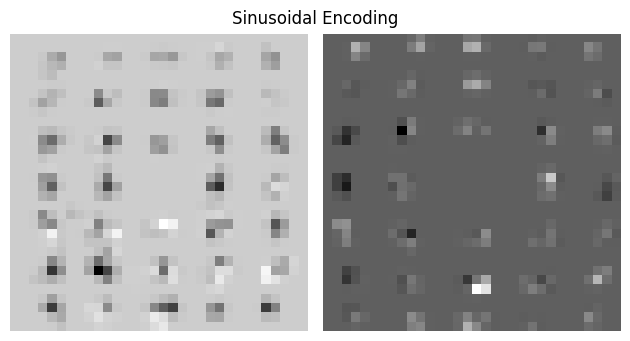

In [ ]:
import matplotlib.pyplot as plt

tensor = preprocessed_frames[602].cpu().squeeze(0)  # shape [2,32,32]
ch0, ch1 = tensor[0], tensor[1]

# Tạo 2 subplots
fig, axes = plt.subplots(1, 2)

# Vẽ ảnh
axes[0].imshow(ch0, cmap='gray')
axes[0].axis('off')
axes[1].imshow(ch1, cmap='gray')
axes[1].axis('off')

# Điều chỉnh để có khoảng trống cho suptitle
plt.tight_layout(rect=[0, 0, 1, 1])

# Đặt tiêu đề chính (suptitle) chính giữa phía trên figure
fig.suptitle('Sinusoidal Encoding', y=0.86)

plt.show()


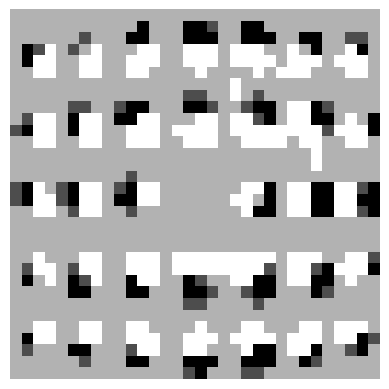

In [9]:
import matplotlib.pyplot as plt

plt.imshow(preprocessed_frames[602].cpu().squeeze(0), cmap='gray', vmin=-0.5, vmax=0.5)         # không chỉ định colormap thì dùng mặc định
plt.axis('off')           # tắt hiển thị trục nếu muốn
plt.show()

In [17]:
# lặp qua từng frame trong list và save thành ảnh

for i, img in enumerate(frame):
    # Chuyển đổi tensor về numpy array

    # Lưu ảnh
    plt.imsave(f'ouput/frame_{i}.png', img, cmap='gray')  # lưu ảnh với tên frame_0.png, frame_1.png, ...
#     plt.imshow(img_np, cmap='gray')

KeyboardInterrupt: 

In [18]:
frame_ts = dv_data_frame_tSlice(r'data\raw_data\raw1.aedat4', duration=10, encoding_type='time_surface')